## Sat processing prototype

### Convert satellite imagery downloaded from land.copernicus.vgt.vito.be into pixel value and s2 cell id

General information can be found on the official website: http://s2geometry.io/

**Step 1.** Get data from site 

**Step 2.**  Load data using netcdf library

**Step 3.**  Filter to rough California area, pickle.

**Step 3b.** Delete raw source images to free harddisk space.

**Step 4.**  Convert lat, lon to s2 cell.



In [74]:
import datetime as dt  # Python standard library datetime  module
import numpy as np
import netCDF4  # http://code.google.com/p/netcdf4-python/
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid

import s2_py as s2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, mapping

import os
import pickle


In [4]:
os.getcwd()

'/home/scott/w210_Wildfire/sat_process'

In [79]:
data_dir = '/home/scott/land.copernicus.vgt.vito.be/'
save_dir = '/home/scott/sat_pickles/'

#### Step 1 Downloading data from site

In [10]:
#!/bin/bash
#wget -r --reject "index.html*" --user='' --password='' https://land.copernicus.vgt.vito.be/PDF/datapool/Vegetation/Properties/FAPAR_300m_V1/2019/


In [16]:
os.getcwd()

'/home/scott/w210_Wildfire/sat_process'

#### Step 2 Load Data using netcdf library

In [60]:
'''
NAME
    NetCDF with Python
PURPOSE
    To demonstrate how to read and write data with NetCDF files using
    a NetCDF file from the NCEP/NCAR Reanalysis.
    Plotting using Matplotlib and Basemap is also shown.
PROGRAMMER(S)
    Chris Slocum
REVISION HISTORY
    20140320 -- Initial version created and posted online
    20140722 -- Added basic error handling to ncdump
                Thanks to K.-Michael Aye for highlighting the issue
REFERENCES
    netcdf4-python -- http://code.google.com/p/netcdf4-python/
    NCEP/NCAR Reanalysis -- Kalnay et al. 1996
        http://dx.doi.org/10.1175/1520-0477(1996)077<0437:TNYRP>2.0.CO;2
'''


def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print( "\t\ttype:", repr(nc_fid.variables[key].dtype))
            for ncattr in nc_fid.variables[key].ncattrs():
                print( '\t\t%s:' % ncattr,\
                      repr(nc_fid.variables[key].getncattr(ncattr)))
        except KeyError:
            print( "\t\tWARNING: %s does not contain variable attributes" % key)

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print( "NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print( '\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print( "NetCDF dimension information:")
        for dim in nc_dims:
            print( "\tName:", dim) 
            print( "\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print( "NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print( '\tName:', var)
                print( "\t\tdimensions:", nc_fid.variables[var].dimensions)
                print( "\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

In [80]:
satfiles = {}
for dirpath, dirnames, filenames in os.walk(data_dir):
    for filename in [f for f in filenames if f.endswith(".nc")]:
        satfiles[filename] = (os.path.join(dirpath, filename))
satfiles

{'c_gls_FAPAR300-RT0_201906100000_GLOBE_PROBAV_V1.0.1.nc': '/home/scott/land.copernicus.vgt.vito.be/PDF/datapool/Vegetation/Properties/FAPAR_300m_V1/2019/06/10/FAPAR300-RT0_201906100000_GLOBE_PROBAV_V1.0.1/c_gls_FAPAR300-RT0_201906100000_GLOBE_PROBAV_V1.0.1.nc',
 'c_gls_FAPAR300_201903310000_GLOBE_PROBAV_V1.0.1.nc': '/home/scott/land.copernicus.vgt.vito.be/PDF/datapool/Vegetation/Properties/FAPAR_300m_V1/2019/03/31/FAPAR300_201903310000_GLOBE_PROBAV_V1.0.1/c_gls_FAPAR300_201903310000_GLOBE_PROBAV_V1.0.1.nc',
 'c_gls_FAPAR300_201903200000_GLOBE_PROBAV_V1.0.1.nc': '/home/scott/land.copernicus.vgt.vito.be/PDF/datapool/Vegetation/Properties/FAPAR_300m_V1/2019/03/20/FAPAR300_201903200000_GLOBE_PROBAV_V1.0.1/c_gls_FAPAR300_201903200000_GLOBE_PROBAV_V1.0.1.nc',
 'c_gls_FAPAR300_201903100000_GLOBE_PROBAV_V1.0.1.nc': '/home/scott/land.copernicus.vgt.vito.be/PDF/datapool/Vegetation/Properties/FAPAR_300m_V1/2019/03/10/FAPAR300_201903100000_GLOBE_PROBAV_V1.0.1/c_gls_FAPAR300_201903100000_GLOBE_PRO

In [94]:
#testFile = satfiles[satfiles.keys()

for k, v in satfiles.items():
    testKey = k
    testFile = v

In [95]:
testKey

'c_gls_FAPAR300-RT2_201905100000_GLOBE_PROBAV_V1.0.1.nc'

In [97]:
testKey[0:-3]

'c_gls_FAPAR300-RT2_201905100000_GLOBE_PROBAV_V1.0.1'

In [91]:
satfiles.items()

dict_items([('c_gls_FAPAR300-RT0_201906100000_GLOBE_PROBAV_V1.0.1.nc', '/home/scott/land.copernicus.vgt.vito.be/PDF/datapool/Vegetation/Properties/FAPAR_300m_V1/2019/06/10/FAPAR300-RT0_201906100000_GLOBE_PROBAV_V1.0.1/c_gls_FAPAR300-RT0_201906100000_GLOBE_PROBAV_V1.0.1.nc'), ('c_gls_FAPAR300_201903310000_GLOBE_PROBAV_V1.0.1.nc', '/home/scott/land.copernicus.vgt.vito.be/PDF/datapool/Vegetation/Properties/FAPAR_300m_V1/2019/03/31/FAPAR300_201903310000_GLOBE_PROBAV_V1.0.1/c_gls_FAPAR300_201903310000_GLOBE_PROBAV_V1.0.1.nc'), ('c_gls_FAPAR300_201903200000_GLOBE_PROBAV_V1.0.1.nc', '/home/scott/land.copernicus.vgt.vito.be/PDF/datapool/Vegetation/Properties/FAPAR_300m_V1/2019/03/20/FAPAR300_201903200000_GLOBE_PROBAV_V1.0.1/c_gls_FAPAR300_201903200000_GLOBE_PROBAV_V1.0.1.nc'), ('c_gls_FAPAR300_201903100000_GLOBE_PROBAV_V1.0.1.nc', '/home/scott/land.copernicus.vgt.vito.be/PDF/datapool/Vegetation/Properties/FAPAR_300m_V1/2019/03/10/FAPAR300_201903100000_GLOBE_PROBAV_V1.0.1/c_gls_FAPAR300_2019031

In [64]:
testFile = satfiles.values()[0]
nc_fid = netCDF4.Dataset(testFile, 'r')  # Dataset is the class behavior to open the file
                             # and create an instance of the ncCDF4 class
nc_attrs, nc_dims, nc_vars = ncdump(nc_fid)
    # Extract data from NetCDF file
lats = nc_fid.variables['lat'][:]  # extract/copy the data
lons = nc_fid.variables['lon'][:]
    
fapar = nc_fid.variables['FAPAR']  # shape is ???, 
type(fapar)

NetCDF Global Attributes:
	Conventions: 'CF-1.6'
	long_name: 'Fraction of Absorbed Photosynthetically Active Radiation'
	processing_mode: 'Near real time'
	references: 'http://land.copernicus.eu/global/products/fapar'
	platform: 'Proba-V'
	copyright: 'Copernicus Service information 2019'
	source: 'Derived from EO satellite imagery'
	archive_facility: 'VITO'
	sensor: 'VEGETATION'
	processing_level: 'L3'
	product_version: 'V1.0.1'
	time_coverage_start: '2018-11-12T00:00:00Z'
	institution: 'VITO NV'
	parent_identifier: 'urn:cgls:global:fapar300_v1_333m'
	time_coverage_end: '2019-06-10T23:59:59Z'
	title: '10-daily Fraction of Absorbed Photosynthetically Active Radiation 333M: GLOBE 2019-06-10T00:00:00Z'
	orbit_type: 'LEO'
	identifier: 'urn:cgls:global:fapar300_v1_333m:FAPAR300-RT0_201906100000_GLOBE_PROBAV_V1.0.1'
	history: 'Processing line GEO3.0: 2019-06-13'
NetCDF dimension information:
	Name: lon
		size: 120960
		type: dtype('float64')
		standard_name: 'longitude'
		long_name: 'longitu

netCDF4._netCDF4.Variable

#### Step 3 Filter to rough California area, pickle.

In [121]:
# California is between West 125 (-125 lon) and 114 (-114 lon), and 32 N and 42 N (32 and 42 lat)
#Get to a coarse grid of CA:

ca_W = lons[18500]
ca_E = lons[22250]
ca_N = lats[12750]
ca_S = lats[16250]
print(ca_W)
print(ca_E)
print(ca_N)
print(ca_S)
latsCa= lats[12750:16250]
lonsCa = lons[18500:22500]
print(latsCa)
print(lonsCa)
print(latsCa.shape)
print(lonsCa.shape) 

-124.94047619022581
-113.77976190446077
42.05357142858006
31.63690476191576
[42.05357143 42.05059524 42.04761905 ... 31.64583333 31.64285714
 31.63988095]
[-124.94047619 -124.9375     -124.93452381 ... -113.04464286 -113.04166667
 -113.03869048]
(3500,)
(4000,)


In [123]:
faparCa = fapar[12750:16250,18500:22250]
faparCa

masked_array(
  data=[[--, --, --, ..., 0.46400001645088196, 0.41600000858306885,
         0.40800002217292786],
        [--, --, --, ..., 0.4480000138282776, 0.4520000219345093,
         0.4400000274181366],
        [--, --, --, ..., 0.41600000858306885, 0.4280000329017639,
         0.4360000193119049],
        ...,
        [--, --, --, ..., 0.04000000283122063, 0.04400000348687172,
         0.052000001072883606],
        [--, --, --, ..., 0.04000000283122063, 0.04800000041723251,
         0.0560000017285347],
        [--, --, --, ..., 0.04400000348687172, 0.04800000041723251,
         0.052000001072883606]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=255,
  dtype=

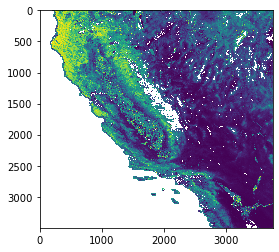

In [70]:
plt.imshow(fapar_ca)

In [127]:
#testFile = satfiles[satfiles.keys()
#testFile
#for k, v in satfiles.items():
 #   print(k)
  #  print(v)

#pickle.dump(fapar_ca, file = os.path.join(save_dir, testKey[0:-3].join('.pkl') ))
faparFile = os.path.join(save_dir, testKey[6:-3] + '.pkl').replace('GLOBE', 'Calif')
latFile = os.path.join(save_dir, testKey[6:-3] + '.pkl').replace('GLOBE', 'Calif').replace('FAPAR', 'Lat')
lonFile = os.path.join(save_dir, testKey[6:-3] + '.pkl').replace('GLOBE', 'Calif').replace('FAPAR', 'Lon')

print('Pickling' + faparFile)
with open(faparFile, 'wb+') as f:
    pickle.dump(faparCa, f)

print('Pickling' + latFile)
with open(latFile, 'wb+') as f:
    pickle.dump(latsCa, f)

print('Pickling' + lonFile)
with open(lonFile, 'wb+') as f:
    pickle.dump(lonsCa, f)



Pickling/home/scott/sat_pickles/FAPAR300-RT2_201905100000_Calif_PROBAV_V1.0.1.pkl
Pickling/home/scott/sat_pickles/Lat300-RT2_201905100000_Calif_PROBAV_V1.0.1.pkl
Pickling/home/scott/sat_pickles/Lon300-RT2_201905100000_Calif_PROBAV_V1.0.1.pkl


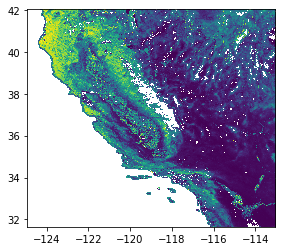

In [151]:
#Check that it worked

del(faparCa)
with open(faparFile, 'rb') as f:
    faparCa = pickle.load(f)

del(latsCa)
with open(latFile, 'rb') as f:
    latsCa = pickle.load(f)

    
del(lonsCa)
with open(lonFile, 'rb') as f:
    lonsCa = pickle.load(f)
    
plt.imshow(faparCa, extent=(lonsCa.min(), lonsCa.max(), latsCa.min(), latsCa.max()))


In [170]:
#Do this for all the files in the dataset

#
def pickleSatFile(filename, fullpath, savedir):
    """Load a netcdf formatted .nc satellite file containing FAPAR data.
    Save pickle files of the FAPAR data and the latitude and longitude listings.
        
    Args:
        filename (str): The full path to the netcdf file, as string.
        param2 (str): The full path to the save directory.

    Returns:
        bool: The return value. True for success, False otherwise.

    """
    
    try:
        #Load data from file
        nc_fid = netCDF4.Dataset(fullpath, 'r')  # Dataset is the class behavior to open the file
                                 # and create an instance of the ncCDF4 class
        #nc_attrs, nc_dims, nc_vars = ncdump(nc_fid)
            # Extract data from NetCDF file
        lats = nc_fid.variables['lat'][:]  # extract/copy the data
        lons = nc_fid.variables['lon'][:]
        fapar = nc_fid.variables['FAPAR']  # shape is ???, 

        # Filter to a coarse grid containing California:
        # California is between West 125 (-125 lon) and 114 (-114 lon), and 32 N and 42 N (32 and 42 lat)
        ca_W = lons[18500]
        ca_E = lons[22250]
        ca_N = lats[12750]
        ca_S = lats[16250]
        latsCa= lats[12750:16250]
        lonsCa = lons[18500:22500]
        faparCa = fapar[12750:16250,18500:22250]
        faparFile = os.path.join(save_dir, filename[6:-3] + '.pkl').replace('GLOBE', 'Calif')

        # Create pickle files
        latFile = os.path.join(save_dir, filename[6:-3] + '.pkl').replace('GLOBE', 'Calif').replace('FAPAR', 'Lat')
        lonFile = os.path.join(save_dir, filename[6:-3] + '.pkl').replace('GLOBE', 'Calif').replace('FAPAR', 'Lon')

        print('Pickling' + faparFile)
        with open(faparFile, 'wb+') as f:
            pickle.dump(faparCa, f)

        print('Pickling' + latFile)
        with open(latFile, 'wb+') as f:
            pickle.dump(latsCa, f)

        print('Pickling' + lonFile)
        with open(lonFile, 'wb+') as f:
            pickle.dump(lonsCa, f)
    
        return True

    except Exception as e:
        print(e)
        return False
    


In [172]:
testKey

'c_gls_FAPAR300-RT2_201905100000_GLOBE_PROBAV_V1.0.1.nc'

In [173]:
satfiles[testKey]

'/home/scott/land.copernicus.vgt.vito.be/PDF/datapool/Vegetation/Properties/FAPAR_300m_V1/2019/05/10/FAPAR300-RT2_201905100000_GLOBE_PROBAV_V1.0.1/c_gls_FAPAR300-RT2_201905100000_GLOBE_PROBAV_V1.0.1.nc'

In [174]:
print(pickleSatFile(testKey, satfiles[testKey], save_dir))

Pickling/home/scott/sat_pickles/FAPAR300-RT2_201905100000_Calif_PROBAV_V1.0.1.pkl
Pickling/home/scott/sat_pickles/Lat300-RT2_201905100000_Calif_PROBAV_V1.0.1.pkl
Pickling/home/scott/sat_pickles/Lon300-RT2_201905100000_Calif_PROBAV_V1.0.1.pkl
True


In [175]:
for filename, fullpath in satfiles.items():
    print(pickleSatFile(filename, fullpath, save_dir))

Pickling/home/scott/sat_pickles/FAPAR300-RT0_201906100000_Calif_PROBAV_V1.0.1.pkl
Pickling/home/scott/sat_pickles/Lat300-RT0_201906100000_Calif_PROBAV_V1.0.1.pkl
Pickling/home/scott/sat_pickles/Lon300-RT0_201906100000_Calif_PROBAV_V1.0.1.pkl
True
Pickling/home/scott/sat_pickles/FAPAR300_201903310000_Calif_PROBAV_V1.0.1.pkl
Pickling/home/scott/sat_pickles/Lat300_201903310000_Calif_PROBAV_V1.0.1.pkl
Pickling/home/scott/sat_pickles/Lon300_201903310000_Calif_PROBAV_V1.0.1.pkl
True
Pickling/home/scott/sat_pickles/FAPAR300_201903200000_Calif_PROBAV_V1.0.1.pkl
Pickling/home/scott/sat_pickles/Lat300_201903200000_Calif_PROBAV_V1.0.1.pkl
Pickling/home/scott/sat_pickles/Lon300_201903200000_Calif_PROBAV_V1.0.1.pkl
True
Pickling/home/scott/sat_pickles/FAPAR300_201903100000_Calif_PROBAV_V1.0.1.pkl
Pickling/home/scott/sat_pickles/Lat300_201903100000_Calif_PROBAV_V1.0.1.pkl
Pickling/home/scott/sat_pickles/Lon300_201903100000_Calif_PROBAV_V1.0.1.pkl
True
Pickling/home/scott/sat_pickles/FAPAR300_2019022

In [177]:
data_dir = '/home/scott/sat_pickles'
picklefiles = {}
for dirpath, dirnames, filenames in os.walk(data_dir):
    for filename in [f for f in filenames if f.endswith(".pkl")]:
        picklefiles[filename] = (os.path.join(dirpath, filename))

{'Lat300_201902280000_Calif_PROBAV_V1.0.1.pkl': '/home/scott/sat_pickles/Lat300_201902280000_Calif_PROBAV_V1.0.1.pkl',
 'Lon300-RT1_201905310000_Calif_PROBAV_V1.0.1.pkl': '/home/scott/sat_pickles/Lon300-RT1_201905310000_Calif_PROBAV_V1.0.1.pkl',
 'Lon300-RT2_201905200000_Calif_PROBAV_V1.0.1.pkl': '/home/scott/sat_pickles/Lon300-RT2_201905200000_Calif_PROBAV_V1.0.1.pkl',
 'FAPAR300_201902200000_Calif_PROBAV_V1.0.1.pkl': '/home/scott/sat_pickles/FAPAR300_201902200000_Calif_PROBAV_V1.0.1.pkl',
 'Lat300_201902100000_Calif_PROBAV_V1.0.1.pkl': '/home/scott/sat_pickles/Lat300_201902100000_Calif_PROBAV_V1.0.1.pkl',
 'Lon300_201902280000_Calif_PROBAV_V1.0.1.pkl': '/home/scott/sat_pickles/Lon300_201902280000_Calif_PROBAV_V1.0.1.pkl',
 'Lon300_201904200000_Calif_PROBAV_V1.0.1.pkl': '/home/scott/sat_pickles/Lon300_201904200000_Calif_PROBAV_V1.0.1.pkl',
 'Lon300_201901100000_Calif_PROBAV_V1.0.1.pkl': '/home/scott/sat_pickles/Lon300_201901100000_Calif_PROBAV_V1.0.1.pkl',
 'Lat300_201901200000_Calif_

In [181]:
import re

In [188]:
fapars ={}
for filename, fullpath in picklefiles.items():
    if filename.startswith('FAPAR'):
        dateStart = filename.find('201')
        date = filename[dateStart:dateStart+8]
        print(filename, date)
        
        with open(fullpath, 'rb') as f:
            fapar = pickle.load(f)
        fapars[date] = fapar
        
#        latFile = os.path.join(save_dir, testKey[6:-3] + '.pkl').replace('GLOBE', 'Calif').replace('FAPAR', 'Lat')
 #       lonFile = os.path.join(save_dir, testKey[6:-3] + '.pkl').replace('GLOBE', 'Calif').replace('FAPAR', 'Lon')


FAPAR300_201902200000_Calif_PROBAV_V1.0.1.pkl 20190220
FAPAR300_201903200000_Calif_PROBAV_V1.0.1.pkl 20190320
FAPAR300_201901200000_Calif_PROBAV_V1.0.1.pkl 20190120
FAPAR300_201902100000_Calif_PROBAV_V1.0.1.pkl 20190210
FAPAR300_201904100000_Calif_PROBAV_V1.0.1.pkl 20190410
FAPAR300_201902280000_Calif_PROBAV_V1.0.1.pkl 20190228
FAPAR300_201903310000_Calif_PROBAV_V1.0.1.pkl 20190331
FAPAR300-RT0_201906100000_Calif_PROBAV_V1.0.1.pkl 20190610
FAPAR300-RT2_201905200000_Calif_PROBAV_V1.0.1.pkl 20190520
FAPAR300_201904200000_Calif_PROBAV_V1.0.1.pkl 20190420
FAPAR300_201903100000_Calif_PROBAV_V1.0.1.pkl 20190310
FAPAR300_201901100000_Calif_PROBAV_V1.0.1.pkl 20190110
FAPAR300-RT2_201905100000_Calif_PROBAV_V1.0.1.pkl 20190510
FAPAR300-RT2_201904300000_Calif_PROBAV_V1.0.1.pkl 20190430
FAPAR300_201901310000_Calif_PROBAV_V1.0.1.pkl 20190131
FAPAR300-RT1_201905310000_Calif_PROBAV_V1.0.1.pkl 20190531


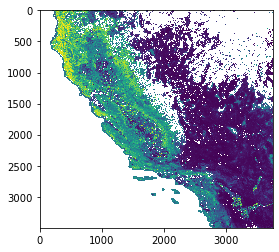

In [195]:
plt.imshow(fapars["20190110"])

<IPython.core.display.Javascript object>


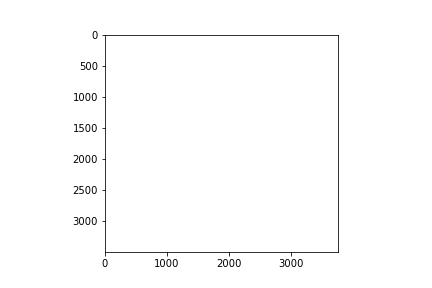

In [208]:
%matplotlib notebook
%matplotlib notebook
import matplotlib.animation as animation

fig = plt.figure()
ims = []
for key in sorted(fapars.keys()):
    im = plt.imshow(fapars[key] , animated = True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval = 50, blit = True,
                               repeat_delay = 1000)
plt.show()


In [ ]:
#def load

faparFile = os.path.join(save_dir, testKey[6:-3] + '.pkl').replace('GLOBE', 'Calif')
latFile = os.path.join(save_dir, testKey[6:-3] + '.pkl').replace('GLOBE', 'Calif').replace('FAPAR', 'Lat')
lonFile = os.path.join(save_dir, testKey[6:-3] + '.pkl').replace('GLOBE', 'Calif').replace('FAPAR', 'Lon')


del(faparCa)
with open(faparFile, 'rb') as f:
    faparCa = pickle.load(f)

del(latsCa)
with open(latFile, 'rb') as f:
    latsCa = pickle.load(f)

    
del(lonsCa)
with open(lonFile, 'rb') as f:
    lonsCa = pickle.load(f)
    
plt.imshow(faparCa, extent=(lonsCa.min(), lonsCa.max(), latsCa.min(), latsCa.max()))


for filename, fullpath in satfiles.items():
    print(pickleSatFile(filename, fullpath, save_dir))

#### DELETE  old images


In [ ]:
#!/bin/bash 
# cd /home/scott/land.copernicus.vgt.vito.be/
# find . -name "*.bak" -type f
# <lists all .nc files>
#  find . -name "*.bak" -type f - delete
# find . -name "*.bak" -type f
# no nc files left to delete


**Step 4.**  Convert lat, lon to s2 cell.
